In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os 

### preprocessing

In [ ]:
import biomart
#comvert ensembl ID to gene symbol
server = biomart.BiomartServer('http://uswest.ensembl.org/biomart',mirror = "useast")    
mart = server.datasets['hsapiens_gene_ensembl']     
attributes = ['ensembl_gene_id','hgnc_symbol']
response = mart.search({'attributes': attributes})                          
data = response.raw.data.decode('ascii')  

## create a conversion table of ensembl id and gene symbol
ensembl_to_genesymbol = {}                                                  
# Store the data in a dict                                                  
for line in data.splitlines():                                              
    line = line.split('\t')                                                 
    # The entries are in the same order as in the `attributes` variable
    transcript_id = line[0]                                                 
    gene_symbol = line[1]                                                                                                
                                                                            
    # Some of these keys may be an empty string. If you want, you can 
    # avoid having a '' key in your dict by ensuring the 
    # transcript/gene/peptide ids have a nonzero length before
    # adding them to the dict
    ensembl_to_genesymbol[gene_symbol] = transcript_id    

ens_id = []
for g in hbv_gene['Gene_symbol'] :
    ens_id.append(ensembl_to_genesymbol[g])   

hbv_conversion_table = pd.DataFrame({'Gene_symbol' : hbv_gene['Gene_symbol'],'Ensembl_ID' :ens_id})
hbv_conversion_table.to_csv(path+'hbv_gene_conversion_table.txt',sep = '\t')      

In [2]:
path = '/home/bruce1996/data/LIHC_anomaly_detection/'

lihc_tumor_exp_profile = path + 'Tumor_matrix_coding_FPKM.txt'
lihc_normal_exp_profile = path + 'Normal_matrix_coding_FPKM.txt'
lihc_tumor = pd.read_csv(lihc_tumor_exp_profile,sep = '\t',index_col=0)
lihc_normal = pd.read_csv(lihc_normal_exp_profile,sep = '\t',index_col=0)
lihc_df = pd.concat([lihc_tumor,lihc_normal],axis = 1)

hbv_conversion_table = pd.read_csv(path + 'lihc/hbv_gene_conversion_table.txt',sep = '\t',index_col=0)
ens_id = hbv_conversion_table['Ensembl_ID'].values        

sample_name =  list(lihc_tumor.columns) + list(lihc_normal.columns)
label =  ['Tumor'] * lihc_tumor.shape[1] + ['Normal'] * lihc_normal.shape[1]
sample_df = pd.DataFrame({'Sample' : sample_name,'Label' : label})

In [46]:
lihc_df = pd.concat([lihc_tumor,lihc_normal],axis = 1)

In [50]:
coding_ens = list(lihc_df.index)
target_ens = list(set(ens_id).union(coding_ens))
target_ens = list(map(lambda x : x.split('.')[0],list(target_ens)))

In [52]:
normal_list = os.listdir(path+'lihc/normal_raw')
normal_uq_df = pd.DataFrame()
for idx,f in enumerate(normal_list) :
    name = f.split('-')[2]
    df = pd.read_csv(path+'lihc/normal_raw/'+normal_list[idx],sep = '\t',header=None)
    df.columns = ['Gene',name]
    if idx == 0 :
        normal_uq_df = df
    else :
        normal_uq_df = normal_uq_df.merge(df,on='Gene',how='left')
        
normal_uq_df.index = normal_uq_df['Gene']
normal_uq_df = normal_uq_df.drop(['Gene'],axis=1)

tumor_list = os.listdir(path+'lihc/tumor_raw')
tumor_uq_df = pd.DataFrame()
for idx,f in enumerate(tumor_list) :
    name = f.split('-')[2]
    df = pd.read_csv(path+'lihc/tumor_raw/'+tumor_list[idx],sep = '\t',header=None)
    df.columns = ['Gene',name]
    if idx == 0 :
        tumor_uq_df = df
    else :
        tumor_uq_df = tumor_uq_df.merge(df,on='Gene',how='left')
        
tumor_uq_df.index = tumor_uq_df['Gene']
tumor_uq_df = tumor_uq_df.drop(['Gene'],axis=1)
lihc_df = pd.concat([tumor_uq_df,normal_uq_df],axis=1)
lihc_df.index = list(map(lambda x : x.split('.')[0],list(lihc_df.index)))

#coding gene
lihc_df_subset = lihc_df.loc[target_ens,:]
lihc_df_subset.to_csv(path + 'lihc_coding_gene_exp_profile.txt',sep = '\t')

### demographic table

In [4]:
clinical_info_file = 'nationwidechildrens.org_clinical_patient_lihc.txt'
clinical_info = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/' + clinical_info_file,sep='\t')
clinical_info = clinical_info.drop([0,1],axis=0)
idx = [x.split('-')[-1] for x in clinical_info['bcr_patient_barcode']]
clinical_info.index = idx

In [5]:
idx = [bool(re.search('Hepatitis B Surface Antigen' ,x )) for x in clinical_info.loc[:,'viral_hepatitis_serology'].values]
hbv_positive = clinical_info.loc[idx,'viral_hepatitis_serology'].index
tmp = []
for x in sample_df['Sample'] :
    if x in hbv_positive :
        tmp.append('Positive')
    else :
        tmp.append('Negative')
sample_df['HBV'] = tmp

In [6]:
hbv_idx = sample_df[sample_df['HBV'] == 'Positive'].index

### Standardization

In [4]:
lihc_df = pd.read_csv(path + 'lihc_coding_gene_exp_profile.txt',sep = '\t',index_col = 0)
#standardization
lihc_hbv_array = lihc_df.T.to_numpy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(lihc_hbv_array)
lihc_df_stand = scaler.transform(lihc_hbv_array)

In [6]:
#subset hbv associated gene 
idx = [x.split('.')[0] in ens_id for x in lihc_df.index]
lihc_hbv_array_stand = lihc_df_stand.T[idx,:]
#principle component analysis after standardization
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
pca = PCA(n_components=2)
hbv_pca = pca.fit(lihc_hbv_array_stand).transform(lihc_hbv_array_stand)

'\nlihc_hbv_stand = pd.DataFrame(lihc_hbv_array_stand)\nscc = lihc_hbv_stand.corr(method=\'spearman\')\nplt.figure(figsize=(15,12))\nsns.clustermap(scc,cmap="YlGnBu", cbar_pos=(-.1, .2, .03, .4))\n#plt.title(\'HBV associated gene spearman corelation heatmap\',fontsize = 20)\nplt.savefig(output_path+\'lihc_hbv_associated_gene_scc_heatmap_after_standardization.png\',dpi = 300)\nplt.show()\n'

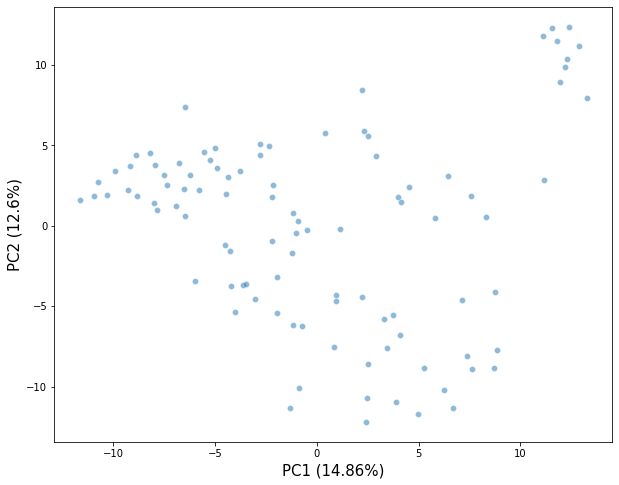

In [9]:
pca_df = pd.DataFrame()
pca_df['PC1'] = hbv_pca[:,0]
pca_df['PC2'] = hbv_pca[:,1]
#pca_df['Tumor'] = sample_df['Label']

pc1_explanation = str(round(pca.explained_variance_ratio_[0] * 100,2))
pc2_explanation = str(round(pca.explained_variance_ratio_[1] * 100,2))

plt.figure(figsize=(10,8))
p = sns.scatterplot(data=pca_df,x='PC1',y='PC2',alpha=0.5)
p.set_xlabel('PC1 (' + pc1_explanation + '%)',fontsize = 15)
p.set_ylabel('PC2 (' + pc2_explanation + '%)',fontsize = 15)
'''
plt.title('LIHC hbv associated gene rbf kernel PCA',fontsize = 15)
output_path = path + 'tmp/'
if os.path.exists(output_path) == False :
    os.mkdir(output_path)
#plt.savefig(output_path + 'lihc_hbv_associated_gene_pca_after_standardization.png',dpi = 300)

'''
'''
lihc_hbv_stand = pd.DataFrame(lihc_hbv_array_stand)
scc = lihc_hbv_stand.corr(method='spearman')
plt.figure(figsize=(15,12))
sns.clustermap(scc,cmap="YlGnBu", cbar_pos=(-.1, .2, .03, .4))
#plt.title('HBV associated gene spearman corelation heatmap',fontsize = 20)
plt.savefig(output_path+'lihc_hbv_associated_gene_scc_heatmap_after_standardization.png',dpi = 300)
plt.show()
'''

### OCSVM

In [37]:
from sklearn.svm import OneClassSVM

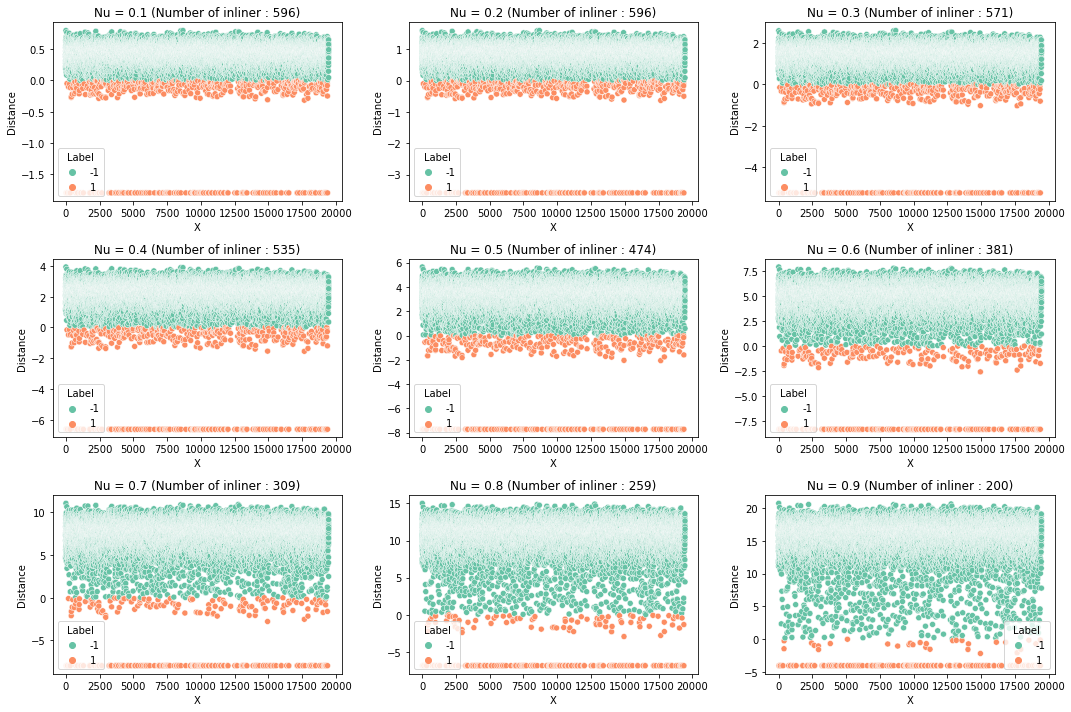

In [81]:
nu_list = np.arange(0.1,1,.1)

fig, axs = plt.subplots(3,3, figsize=(15, 10))
axs = axs.ravel()

X = lihc_hbv_array_stand
test_idx = [x.split('.')[0] not in ens_id for x in lihc_df.index]
x_test = lihc_df_stand.T[test_idx,:]

for idx,n in enumerate(nu_list) :

    ocsvm = OneClassSVM(gamma='scale',kernel='rbf',nu = n).fit(X)
    label = ocsvm.predict(x_test)
    distance = ocsvm.decision_function(x_test) * -1
    xaxis = np.arange(len(distance))
    y = distance
    df = pd.DataFrame({'X' : xaxis,'Distance' : distance,'Label' : label})
    sns.scatterplot(data = df,x = 'X',y = 'Distance',hue='Label',palette='Set2',ax = axs[idx])
    n_inliner = sum(label == 1)
    axs[idx].set_title('Nu = %0.1f (Number of inliner : %d)' %(n,n_inliner) )

plt.tight_layout()
plt.savefig(output_path + 'differ_nu_ocsvm_result_in_negative_dataset.png',dpi = 300)


In [51]:
inliner_idx = label == 1
other_gene = lihc_df.index[test_idx]
inliner =  other_gene[inliner_idx]
lihc_target_gene = list(ens_id) + list(inliner)

In [54]:
idx = [x.split('.')[0] in ens_id for x in lihc_df.index]
lihc_hbv_associated_stand = lihc_df_stand.T[idx,:]
#principle component analysis after standardization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
hbv_pca = pca.fit(lihc_hbv_associated_stand).transform(lihc_hbv_associated_stand)

/home/bruce1996/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


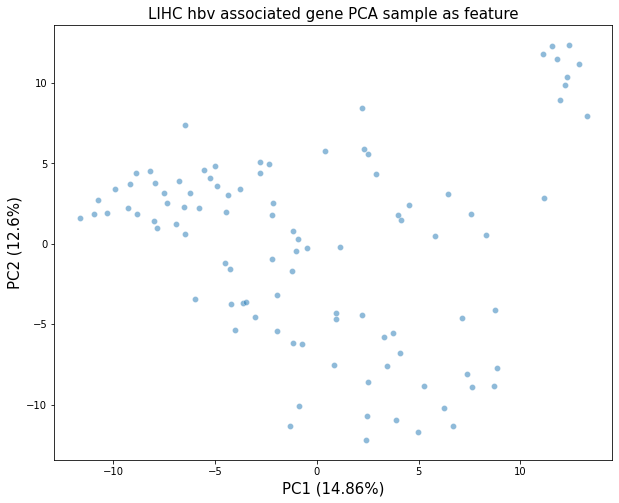

<Figure size 1080x864 with 0 Axes>

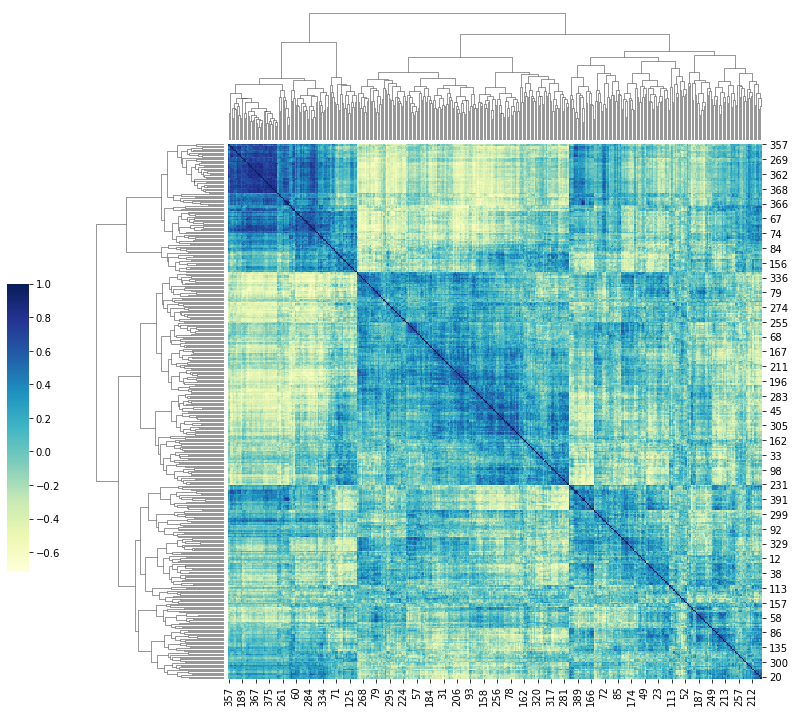

In [55]:
pca_df = pd.DataFrame()
pca_df['PC1'] = hbv_pca[:,0]
pca_df['PC2'] = hbv_pca[:,1]
pc1_explanation = str(round(pca.explained_variance_ratio_[0] * 100,2))
pc2_explanation = str(round(pca.explained_variance_ratio_[1] * 100,2))

plt.figure(figsize=(10,8))
p = sns.scatterplot(data=pca_df,x='PC1',y='PC2',alpha=0.5)
p.set_xlabel('PC1 (' + pc1_explanation + '%)',fontsize = 15)
p.set_ylabel('PC2 (' + pc2_explanation + '%)',fontsize = 15)
plt.title('LIHC hbv associated gene PCA sample as feature',fontsize = 15)
output_path = path + 'tmp/'
if os.path.exists(output_path) == False :
    os.mkdir(output_path)
#plt.savefig(output_path + 'lihc_hbv_associated_gene_pca_after_standardization.png',dpi = 300)


lihc_hbv_stand = pd.DataFrame(lihc_hbv_associated_stand)
scc = lihc_hbv_stand.corr(method='spearman')
plt.figure(figsize=(15,12))
sns.clustermap(scc,cmap="YlGnBu", cbar_pos=(-.1, .2, .03, .4))
#plt.title('HBV associated gene spearman corelation heatmap',fontsize = 20)
plt.savefig(output_path+'lihc_hbv_associated_gene_scc_heatmap_after_standardization.png',dpi = 300)
plt.show()

### SVDD

In [82]:
sys.path.append("/home/bruce1996/tools/SVDD-Python/")
from src.BaseSVDD import BaseSVDD



*** Fitting of the SVDD model is completed. ***

running time         = 0.0297 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 99
number of features   = 398
number of SVs        = 50
ratio of SVs         = 50.5051 %
accuracy             = 52.5253 %




/home/bruce1996/tools/SVDD-Python/src/BaseSVDD.py:255: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


Text(0.5, 1.0, 'LIHC anomaly detection by SVDD (Number of inliner : 52)')

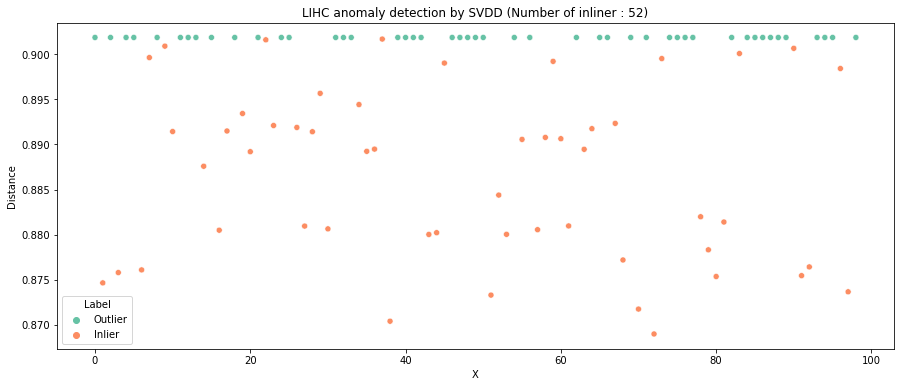

In [83]:
X = lihc_hbv_array_stand
test_idx = [x.split('.')[0] not in ens_id for x in lihc_df.index]
x_test = lihc_df_stand.T[test_idx,:]

svdd = BaseSVDD(kernel='rbf')
svdd.fit(X)
radius = svdd.radius
distance = svdd.get_distance(X)
label = []
for x in distance :
    if x > radius :
        label.append('Outlier')
    else :
        label.append('Inlier')

xaxis = np.arange(len(distance))
y = np.asarray(distance).reshape(-1)
df = pd.DataFrame({'X' : xaxis,'Distance' : y,'Label' : label})
plt.figure(figsize=(15,6))
sns.scatterplot(data = df,x = 'X',y = 'Distance',hue='Label',palette='Set2')
idx = [i for i,x in enumerate(label) if x== 'Inlier'] # => [1, 3]
n_inliner = len(idx)
plt.title('LIHC anomaly detection by SVDD (Number of inliner : %d)' %n_inliner)
#plt.savefig(output_path + 'lihc_ae_by_ocsvm.png',dpi = 300)


### Ensemble learning

In [15]:
#subset hbv associated gene 
idx = [x.split('.')[0] in ens_id for x in lihc_df.index]
lihc_hbv = lihc_df_stand.T[idx,:]
n_idx = [x == False for x in idx]
lihc_no_hbv = lihc_df_stand.T[n_idx,:]

In [16]:
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import precision_score,confusion_matrix
import multiprocessing as mp

In [25]:
def specificity(y_true,y_pred) :
    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    return specificity

def npv(y_true,y_pred) :
    tn, _, fn, _ = confusion_matrix(y_true, y_pred).ravel()
    npv = tn / (tn+fn)
    return npv

In [31]:
class svm_ensemble_learning() :
    def __init__(self,p_m,n_m,all_m,y_all,r = 1,t = 20):
        self.positive_matrix = p_m
        self.negative_matrix = n_m
        self.overall_matrix = all_m
        self.y_overall = y_all
        self.ratio = r
        self.threads = t
        
    def single_svm(self,n) :
        p_array = np.zeros(4)
        population = range(self.negative_matrix.shape[0])
        n_sample = self.ratio * self.positive_matrix.shape[0]
        idx = random.sample(population,n_sample)
        negative = self.negative_matrix[idx,:]
        positive = self.positive_matrix
        X = np.concatenate((positive,negative))
        y = np.concatenate((np.repeat(1,positive.shape[0]),np.repeat(0,negative.shape[0]) ))

        x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)
        svm = SVC(kernel='linear')
        svm.fit(x_train,y_train)
        #prediction and measure model performance
        y_pred = svm.predict(x_test)
        p_array[0] = precision_score(y_test,y_pred,average='binary')
        y_pred_overall = svm.predict(self.overall_matrix)
        p_array[1] = precision_score(y_overall,y_pred_overall,average= 'binary')
        #NPV for negative performance
        p_array[2] = npv(y_test,y_pred)
        p_array[3] = npv(y_overall,y_pred_overall)

        return p_array

    def ensemble_svm(self) :
        pool = mp.Pool(self.threads)
        n_run = 1000
        result = pool.map(self.single_svm,range(n_run))
        pool.close()
        pool.join()
        #merge parallel result
        metric_array = np.stack(result,axis = 0)
        metric_df = pd.DataFrame(metric_array,columns = ['Precision','Precision_overall','NPV','NPV_overall'])
        metric_df['Ratio'] = [str(self.ratio)] * n_run

        return metric_df

In [35]:
y_overall = np.zeros(lihc_df_stand.T.shape[0])
idx = [x.split('.')[0] in ens_id for x in lihc_df.index]
y_overall[idx] = 1

svm_ensemble = svm_ensemble_learning(lihc_hbv,lihc_no_hbv,lihc_df_stand.T,y_overall,t = 40)

ratio = np.arange(1,6,1)
metric_df = pd.DataFrame()
for r in ratio :
    svm_ensemble.ratio = r
    df = svm_ensemble.ensemble_svm()
    metric_df = pd.concat([metric_df,df],axis = 0)

In [ ]:
box_df = metric_df.melt(id_vars='Ratio')
box_df.columns = ['Ratio','Metric','Value']
plt.figure(figsize=(15,6))
sns.boxplot(data = box_df,x = 'Ratio',y='Value',hue = 'Metric',palette='Set3')
plt.title('LIHC anomaly detection by ensemble learning in different positive/negative ratio')
output_path = '/home/bruce1996/data/LIHC_anomaly_detection/tmp/'
#plt.savefig(output_path + 'lihc_ae_ensemble_boxplot_n_1000.png',dpi = 300)

In [94]:
#subset by sample have HBV surface antigen
lihc_hbv_hbv_subset = lihc_hbv[:,hbv_idx]
lihc_no_hbv_hbv_subset = lihc_no_hbv[:,hbv_idx]
lihc_df_hbv_subset = lihc_df_stand.T[:,hbv_idx]

In [97]:
y_overall = np.zeros(lihc_df_stand.T.shape[0])
idx = [x.split('.')[0] in ens_id for x in lihc_df.index]
y_overall[idx] = 1

svm_ensemble = svm_ensemble_learning(lihc_hbv_hbv_subset,lihc_no_hbv_hbv_subset,lihc_df_hbv_subset,y_overall,t = 40)

ratio = np.arange(5,55,5)
metric_df = pd.DataFrame()
for r in ratio :
    svm_ensemble.ratio = r
    df = svm_ensemble.ensemble_svm()
    metric_df = pd.concat([metric_df,df],axis = 0)

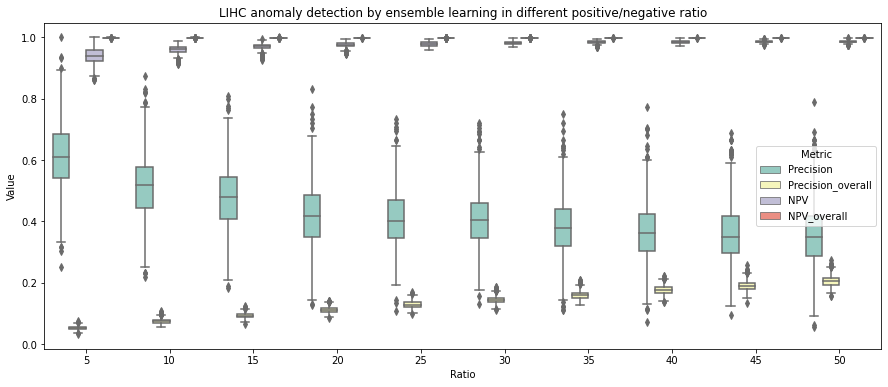

In [99]:
box_df = metric_df.melt(id_vars='Ratio')
box_df.columns = ['Ratio','Metric','Value']
plt.figure(figsize=(15,6))
sns.boxplot(data = box_df,x = 'Ratio',y='Value',hue = 'Metric',palette='Set3')
plt.title('LIHC anomaly detection by ensemble learning in different positive/negative ratio')
output_path = '/home/bruce1996/data/LIHC_anomaly_detection/tmp/'
plt.savefig(output_path + 'lihc_ae_ensemble_boxplot_only_HBV_positive.png',dpi = 300)